In [1]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
import numpy as np
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import os
from keras.preprocessing.image import array_to_img
import tensorflow as tf

import matplotlib.pyplot as plt

# 加载训练集
train = np.load('/shuyc_tmp/models/tensorflow/uNet/skin_dataset/data_train.npy')
# 加载训练集的mask 
mask = np.load('/shuyc_tmp/models/tensorflow/uNet/skin_dataset/mask_train.npy')
# 加载测试集
test = np.load('/shuyc_tmp/models/tensorflow/uNet/skin_dataset/data_test.npy')
# 归一化处理
train = train.astype('float32')
train = train/255.
mask = mask /mask.max()

test = test.reshape((test.shape[0],256,256,3))
test = test.astype('float32')
test = test/255.
train = train.reshape(train.shape[0], 256, 256, 3)
mask = mask.reshape(mask.shape[0], 256, 256, 1)

##train = train[0]


# 定义u-Net网络模型
def Unet():
    # contraction path
    # 输入层数据为256*256的三通道图像
    inputs = Input(shape=[256, 256, 3])
    # 第一个block(含两个激活函数为relu的有效卷积层 ，和一个卷积最大池化(下采样)操作)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    # 最大池化
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # 第二个block(含两个激活函数为relu的有效卷积层 ，和一个卷积最大池化(下采样)操作)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # 第三个block(含两个激活函数为relu的有效卷积层 ，和一个卷积最大池化(下采样)操作)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # 第四个block(含两个激活函数为relu的有效卷积层 ，和一个卷积最大池化(下采样)操作)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    # 将部分隐藏层神经元丢弃，防止过于细化而引起的过拟合情况
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    # 将部分隐藏层神经元丢弃，防止过于细化而引起的过拟合情况
    drop5 = Dropout(0.5)(conv5)

    # expansive path
    # 上采样
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    # copy and crop(和contraction path 的feature map合并拼接)
    merge6 = concatenate([drop4, up6], axis=3)
    # 两个有效卷积层
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    # 上采样
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # 上采样
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    # 上采样
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    
    # 优化器为 Adam,损失函数为 binary_crossentropy，评价函数为 accuracy
    model.compile(optimizer=Adam(lr=1e-4),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [2]:
# 开始训练
unet = Unet()
# 每个epoch后保存模型到 uNet_Skin.hdf5
model_checkpoint = ModelCheckpoint('./uNet_Skin.hdf5',monitor='loss',verbose=1,save_best_only=True)
# 训练
history = unet.fit(train, mask, batch_size=4, epochs=30, verbose=1, 
                   validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])


Train on 1452 samples, validate on 363 samples
Epoch 1/30
1452/1452 [==============================] - 47s 32ms/step - loss: 0.3944 - accuracy: 0.8391 - val_loss: 0.2998 - val_accuracy: 0.8964

Epoch 00001: loss improved from inf to 0.39441, saving model to ./uNet_Skin.hdf5
Epoch 2/30
1452/1452 [==============================] - 40s 27ms/step - loss: 0.3288 - accuracy: 0.8822 - val_loss: 0.3054 - val_accuracy: 0.8803

Epoch 00002: loss improved from 0.39441 to 0.32879, saving model to ./uNet_Skin.hdf5
Epoch 3/30
1452/1452 [==============================] - 40s 27ms/step - loss: 0.3063 - accuracy: 0.8885 - val_loss: 0.2598 - val_accuracy: 0.9166

Epoch 00003: loss improved from 0.32879 to 0.30633, saving model to ./uNet_Skin.hdf5
Epoch 4/30
1452/1452 [==============================] - 40s 27ms/step - loss: 0.2864 - accuracy: 0.9044 - val_loss: 0.2475 - val_accuracy: 0.9261

Epoch 00004: loss improved from 0.30633 to 0.28638, saving model to ./uNet_Skin.hdf5
Epoch 5/30
1452/1452 [=======

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


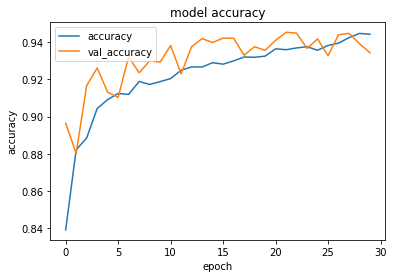

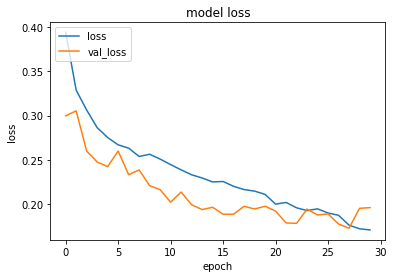

In [3]:
print(history.history.keys()) # dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

# 展示一下精确度随训练的变化图
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

# 展示一下loss随训练的变化图
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()



In [5]:
# 预测
predict_img = unet.predict(test,batch_size=4,verbose=1)

# 阈值化，大于0.5的为1, 小于0.5的为0（背景）
predict_img[predict_img >= 0.5] = 1
predict_img[predict_img < 0.5] = 0

# 加载 ground_truth_mask
gt_mask = np.load('/shuyc_tmp/models/tensorflow/uNet/skin_dataset/mask_test.npy')
gt_mask = gt_mask / gt_mask.max()
gt_mask = gt_mask.reshape(gt_mask.shape[0], 256, 256, 1)

# 调用keras的Precision接口 计算分割结果的 precision
precision = tf.keras.metrics.Precision()
precision.update_state(gt_mask, predict_img)
pre = precision.result().numpy()
print("precision = " + str(pre))
# 调用keras的Recall接口 计算分割结果的 Recall
recall = tf.keras.metrics.Recall()
recall.update_state(gt_mask, predict_img)
recall = recall.result().numpy()
print("recall = " + str(recall))

# 计算 f1_score = (precision * recall) / (precision + recall)
F1 = 2 * (pre * recall) / (pre + recall)
print("f1 score = " + str(F1))


520/520 [==============================] - 4s 8ms/step
precision = 0.9744628
recall = 0.67491066
f1 score = 0.7974850006663801
